In [1]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import os, sys, pickle
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    
SRATE = 300
LEN_INPUT = 60
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60
SEED = 98

os.environ["CUDA_VISIBLE_DEVICES"]= "3"
seed_everything(SEED)

print(datetime.datetime.now())

2022-12-07 21:26:16.594703


In [16]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
SRATE = 300
LEN_INPUT = 30
OVERLAP = 0
LEN_PER_PRE = 30
LEN_PER_POST = 30

ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
HR_THRES = 0.25

hyper_path = f'SRATE{SRATE}_LEN{LEN_INPUT}-PRE{LEN_PER_PRE}-POST{LEN_PER_POST}_STR{OVERLAP}_PPG-{PPG_FILT}_ECG-{ECG_FILT}'
input_path = f"../DL_model/dataset/PD_{hyper_path}/"


x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
rftn_train = np.load(input_path+'rftn_train.npz')['arr_0']
rftn_test = np.load(input_path+'rftn_test.npz')['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
c_train = np.load(input_path+'c_train.npz')['arr_0']
c_test = np.load(input_path+'c_test.npz')['arr_0']


y_train_bin = y_train > HR_THRES
y_test_bin = y_test > HR_THRES

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']

rftn_train = np.reshape(rftn_train, [-1,LEN_INPUT*SRATE,1])
input_train = np.concatenate((x_train, rftn_train), axis=2)
rftn_test = np.reshape(rftn_test, [-1,LEN_INPUT*SRATE,1])
input_test = np.concatenate((x_test, rftn_test), axis=2)


print('done', flush=True)

print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)

print(f'y_train : mean {y_train.mean():.2f}, max {y_train.max():.2f}, min {y_train.min():.2f}')
print(f'y_test : mean {y_test.mean():.2f}, max {y_test.max():.2f}, min {y_test.min():.2f}')

print(datetime.datetime.now())

loading train...done
input_train shape: (965, 9000, 3)
input_test.shape: (107, 9000, 3)
y_train : mean 0.24, max 2.49, min -0.77
y_test : mean 0.23, max 1.00, min -0.22
2022-12-08 01:50:23.685757


## output distribution

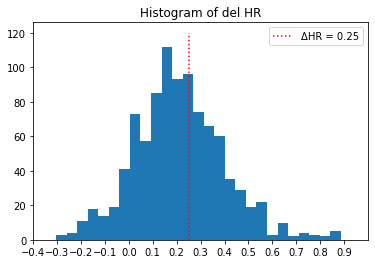

In [44]:
plt.hist(np.concatenate([y_train,y_test]), bins=40, density=False, cumulative=False, histtype='bar')
plt.xlim([0,1])
plt.xticks(np.arange(-0.4,1,step=0.1))
plt.vlines(0.25,0,120, colors='r', linestyles='dotted', label='ΔHR = 0.25')
plt.title('Histogram of del HR')
plt.legend()
plt.show()

#plt.hist(y_test, bins=20)
#plt.xlim([0,1])
#plt.xticks(np.arange(0,1,step=0.1))
#plt.show()

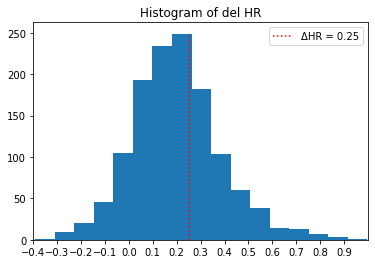

In [9]:
plt.hist(np.concatenate([y_train,y_test]), bins=40, density=False, cumulative=False, histtype='bar')
plt.xlim([0,1])
plt.xticks(np.arange(-0.4,1,step=0.1))
plt.vlines(0.25,0,250, colors='r', linestyles='dotted', label='ΔHR = 0.25')
plt.title('Histogram of del HR')
plt.legend()
plt.show()

#plt.hist(y_test, bins=20)
#plt.xlim([0,1])
#plt.xticks(np.arange(0,1,step=0.1))
#plt.show()

# Model
## setting

In [17]:
train_w_samp = np.ones(shape=(len(y_train),))
#val_w_samp = np.ones(shape=(len(y_val),))
test_w_samp = np.ones(shape=(len(y_test),))


# folder
nfold = 5  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 1000
rootdir = f"../DL_model/randomSearch/HR_PD/CNN_HR{HR_THRES}_{hyper_path}_{nfold}fold_w_samp0_seed{SEED}"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: 1D CNN 4 layers, binary classification')
f.write(f'input: ECG,PPG,RFTN of pre-intubation 120~60s, output: del HR 0.25 (post-intubation 0-60s)')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters
#num_nodes = [64, 64, 64] #, 64, 64, 64]
#kernel_size = 10
pool_size = 2

#dense_node = 32
#dropout_rate = 0.2
learning_rate = 0.001

# hyperparamters pool
filt_opts = [16, 32, 64, 128] # num of filters(kernel)
stride_opts = [1,2,3]  # stride = (kernel-1)/2
kernel_opts = range(3,17,2) # kernel size
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [0, 8, 16, 32, 64]
globalpool_opts = ['max','ave']
BATCH_SIZE = [32, 64, 128, 256, 512]

print('start making test settings...', end='', flush=True)
# test settings
nfilt, kernels, strides = [], [], []
for i in range(5):
    nfilt.append(0)
    kernels.append(0)
    strides.append(0)

for nfilter in filt_opts:
    for kernel in kernel_opts:
        for stride in stride_opts:
        #layer_settings.append([nfilter, kernel, int((kernel-1)/2)])       
            layer_settings.append([nfilter, kernel, stride])
    
for dense_node in dense_opts:
    for dropout_cnn in dropout_opts:
        for dropout_fc in dropout_opts:
            for globalpool_opt in globalpool_opts:
                for batch_size in BATCH_SIZE:
                    for conv_double in [True, False]:
                        for learning_rate in [0.001, 0.002, 0.0005]:
                            test_settings.append([dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2022-12-08 01:50:56.034872


ntest

## simple block

In [18]:
from keras import metrics
from scipy import interp
from sklearn.metrics import roc_curve,auc
import tensorflow.python.keras.backend as K

seed_everything(SEED)
# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4]) 
    # test settings
    for i in range(n_conv):
        nfilt[i], kernels[i], strides[i] = random.choice(layer_settings)
    dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(n_conv):
        odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
    odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

    #weightcache = f"{odir}/weights.hdf5"    
    # build a model

    inp = Input(shape=(x_train.shape[1],3))
    out = inp

    
    # VGC block
    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = BatchNormalization()(out)
        out = MaxPooling1D(pool_size)(out)
    

    # globalpooling vs flattening vs 1x1 convolution
    #if globalpool_opt == 'max':
    #    out = GlobalMaxPooling1D()(out)
    #elif globalpool_opt == 'ave':
    #    out = GlobalAveragePooling1D()(out)
    out = Conv1D(filters=1, kernel_size=1)(out)
    out = Flatten() (out)


    if dense_node != 0:
        out = Dropout(dropout_cnn)(out)
        out = Dense(dense_node, activation='relu')(out)
    out = Dropout(dropout_fc)(out)
    out = Dense(1, activation='sigmoid')(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')

    # model 학습 설정
    kfold = KFold()
    cv_scores = []
    tprs, aucs, prs = [], [], []
    pr_aucs, roc_aucs = [], []
    mean_fpr = np.linspace(0,1,100)
    mean_recall = np.linspace(0,1,100)
    idx = 1
    
    switch = 0
    caseids_train = np.unique(c_train)
    for c_cv_trains_mask, c_cv_test_mask in kfold.split(caseids_train):
        c_cv_trains = caseids_train[c_cv_trains_mask]
        random.shuffle(c_cv_trains)
        
        ncv = int(len(c_cv_trains)*0.8)
        c_cv_train = c_cv_trains[:ncv]
        c_cv_val = c_cv_trains[ncv:]
        
        cv_train_mask = np.isin(c_train, c_cv_train)
        cv_val_mask = np.isin(c_train, c_cv_val)
        cv_test_mask = np.isin(c_train, caseids_train[c_cv_test_mask])
        
        
        try:
            weightcache = f"{odir}/weights_{idx}.hdf5"
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(input_train[cv_train_mask], y_train_bin[cv_train_mask], validation_data=(input_train[cv_val_mask], y_train_bin[cv_val_mask]), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
            model.load_weights(weightcache)
            #_, cv_score = model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask], batch_size=batch_size, verbose=0)

            # ROC analysis
            fpr, tpr, t = roc_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            # PR analysis
            prec, recall, th = precision_recall_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            prs.append(interp(mean_recall, prec, recall))
            pr_auc = auc(recall, prec)
            pr_aucs.append(pr_auc)

            print(f' ###{idx} fold : val auc {roc_auc:.3f}, val prc {pr_auc:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')
            idx += 1
            #cv_scores.append(cv_score)

        except Exception as e:
            print(e)
            switch = 1
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            break
            
    if switch:
        switch = 0
        continue

            
    max_idx = roc_aucs.index(max(roc_aucs))
    # mean ROC
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_roc = np.std(roc_aucs)
    # mean PRC
    mean_precision = np.mean(prs, axis = 0)
    mean_prc = auc(mean_recall, mean_precision)
    std_prc = np.std(pr_aucs)
    
    print(f'roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_max{max_idx+1}')
        
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())
    # rename
    os.rename(odir, rootdir+f'/roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_max{max_idx+1}_{odir_f}')
    tf.keras.backend.clear_session()




random search 0/1000


2022-12-08 01:51:07.669480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 01:51:08.413634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


Epoch 1/100


2022-12-08 01:51:11.505673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-12-08 01:51:12.012447: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 6/10 [=================>............] - ETA: 0s - loss: 0.9601 - acc: 0.5182 - auc: 0.53562 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model/dense_1/Sigmoid:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[node assert_greater_equal/Assert/AssertGuard/Assert
 (defined at /home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py:193)
]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_55]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model/dense_1/Sigmoid:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[node assert_greater_equal/Assert/AssertGuard/Assert
 (defined at /home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py:193)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_244

OSError: [Errno 39] Directory not empty: '../DL_model/randomSearch/HR_PD/CNN_HR0.25_SRATE300_LEN30-PRE30-POST30_STR0_PPG-lowess_ECG-3rd-bandpass_5fold_w_samp0_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0'

## VGC block

In [ ]:
from keras import metrics
from scipy import interp
from sklearn.metrics import roc_curve,auc
import tensorflow.python.keras.backend as K

seed_everything(SEED)
# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4]) 
    # test settings
    for i in range(n_conv):
        nfilt[i], kernels[i], strides[i] = random.choice(layer_settings)
    dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(n_conv):
        odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
    odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

    #weightcache = f"{odir}/weights.hdf5"    
    # build a model

    inp = Input(shape=(x_train.shape[1],3))
    out = inp
    
    # VGC block
    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = MaxPooling1D(pool_size)(out)
    
    

    # globalpooling vs flattening vs 1x1 convolution
    #if globalpool_opt == 'max':
    #    out = GlobalMaxPooling1D()(out)
    #elif globalpool_opt == 'ave':
    #    out = GlobalAveragePooling1D()(out)
    out = Conv1D(filters=1, kernel_size=1)(out)
    out = Flatten() (out)


    if dense_node != 0:
        out = Dropout(dropout_cnn)(out)
        out = Dense(dense_node, activation='relu')(out)
    out = Dropout(dropout_fc)(out)
    out = Dense(1, activation='sigmoid')(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')

    # model 학습 설정
    kfold = KFold()
    cv_scores = []
    tprs, aucs, prs = [], [], []
    pr_aucs, roc_aucs = [], []
    mean_fpr = np.linspace(0,1,100)
    mean_recall = np.linspace(0,1,100)
    idx = 1
    
    switch = 0
    caseids_train = np.unique(c_train)
    for c_cv_trains_mask, c_cv_test_mask in kfold.split(caseids_train):
        c_cv_trains = caseids_train[c_cv_trains_mask]
        random.shuffle(c_cv_trains)
        
        ncv = int(len(c_cv_trains)*0.8)
        c_cv_train = c_cv_trains[:ncv]
        c_cv_val = c_cv_trains[ncv:]
        
        cv_train_mask = np.isin(c_train, c_cv_train)
        cv_val_mask = np.isin(c_train, c_cv_val)
        cv_test_mask = np.isin(c_train, caseids_train[c_cv_test_mask])
        
        
        try:
            weightcache = f"{odir}/weights_{idx}.hdf5"
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(input_train[cv_train_mask], y_train_bin[cv_train_mask], validation_data=(input_train[cv_val_mask], y_train_bin[cv_val_mask]), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
            model.load_weights(weightcache)
            #_, cv_score = model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask], batch_size=batch_size, verbose=0)

            # ROC analysis
            fpr, tpr, t = roc_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            # PR analysis
            prec, recall, th = precision_recall_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            prs.append(interp(mean_recall, prec, recall))
            pr_auc = auc(recall, prec)
            pr_aucs.append(pr_auc)

            print(f' ###{idx} fold : val auc {roc_auc:.3f}, val prc {pr_auc:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')
            idx += 1
            #cv_scores.append(cv_score)

        except Exception as e:
            print(e)
            switch = 1
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            break

    
    if switch:
        switch = 0
        continue
        
    max_idx = roc_aucs.index(max(roc_aucs))
    # mean ROC
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_roc = np.std(roc_aucs)
    # mean PRC
    mean_precision = np.mean(prs, axis = 0)
    mean_prc = auc(mean_recall, mean_precision)
    std_prc = np.std(pr_aucs)
    
    print(f'roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_max{max_idx+1}')
        
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())
    # rename
    os.rename(odir, rootdir+f'/roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_max{max_idx+1}_{odir_f}')
    tf.keras.backend.clear_session()




random search 0/2000


2022-12-06 17:35:44.023745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:35:44.726803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


Epoch 1/100


2022-12-06 17:35:47.544528: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-12-06 17:35:48.205453: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


9/9 [==============================] - ETA: 0s - loss: 0.6811 - acc: 0.5660 - auc: 0.4930
Epoch 00001: val_loss improved from inf to 0.66178, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_1.hdf5
9/9 [==============================] - 5s 183ms/step - loss: 0.6811 - acc: 0.5660 - auc: 0.4930 - val_loss: 0.6618 - val_acc: 0.6259 - val_auc: 0.6529
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6456 - acc: 0.6387 - auc: 0.5769
Epoch 00002: val_loss improved from 0.66178 to 0.65338, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_1.hdf5
9/9 [==============================] - 1s 7

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.593, val prc 0.557###
Epoch 1/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6763 - acc: 0.5703 - auc: 0.5597
Epoch 00001: val_loss improved from inf to 0.77276, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_2.hdf5
9/9 [==============================] - 2s 115ms/step - loss: 0.6727 - acc: 0.5787 - auc: 0.5617 - val_loss: 0.7728 - val_acc: 0.5899 - val_auc: 0.5810
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6849 - acc: 0.6191 - auc: 0.5059
Epoch 00002: val_loss improved from 0.77276 to 0.67920, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/w

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.626, val prc 0.460###
Epoch 1/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6902 - acc: 0.5078 - auc: 0.5076
Epoch 00001: val_loss improved from inf to 0.64601, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_3.hdf5
9/9 [==============================] - 2s 116ms/step - loss: 0.6852 - acc: 0.5208 - auc: 0.5207 - val_loss: 0.6460 - val_acc: 0.6475 - val_auc: 0.6184
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6893 - acc: 0.5742 - auc: 0.5230
Epoch 00002: val_loss did not improve from 0.64601
9/9 [==============================] - 1s 66ms/step - loss: 0.6879 - acc: 0.5877 - auc: 0.5210 - val_loss: 0.6752 - val_acc: 0.6259 - val_auc: 0.5914
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6758 - acc: 0.5879 - auc:

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.702, val prc 0.465###
Epoch 1/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6802 - acc: 0.5547 - auc: 0.5337
Epoch 00001: val_loss improved from inf to 0.66819, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_4.hdf5
9/9 [==============================] - 2s 117ms/step - loss: 0.6783 - acc: 0.5588 - auc: 0.5344 - val_loss: 0.6682 - val_acc: 0.6187 - val_auc: 0.6135
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6641 - acc: 0.6074 - auc: 0.5995
Epoch 00002: val_loss improved from 0.66819 to 0.63815, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/w

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###4 fold : val auc 0.640, val prc 0.427###
Epoch 1/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6664 - acc: 0.5957 - auc: 0.5503
Epoch 00001: val_loss improved from inf to 0.77958, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/weights_5.hdf5
9/9 [==============================] - 2s 115ms/step - loss: 0.6730 - acc: 0.5949 - auc: 0.5346 - val_loss: 0.7796 - val_acc: 0.5324 - val_auc: 0.6199
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.6649 - acc: 0.6445 - auc: 0.4919
Epoch 00002: val_loss improved from 0.77958 to 0.68941, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch64,layer1:c128filt9str2,layer2:c16filt5str3,layer3:c64filt5str1,1conv,dropout0.1,dnodes32,dropout0/w

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###5 fold : val auc 0.637, val prc 0.481###
roc0.640+-0.036_prc0.495+-0.043_max3
random search 1/2000
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6934 - acc: 0.4937 - auc: 0.4850
Epoch 00001: val_loss improved from inf to 0.68344, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0.5/weights_1.hdf5
3/3 [==============================] - 2s 318ms/step - loss: 0.6934 - acc: 0.4937 - auc: 0.4850 - val_loss: 0.6834 - val_acc: 0.6115 - val_auc: 0.5095
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6745 - acc: 0.6230 - auc: 0.5670
Epoch 00002: val_loss improved from 0.68344 to 0.66821, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5s

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.573, val prc 0.501###
Epoch 1/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6939 - acc: 0.4746 - auc: 0.5091
Epoch 00001: val_loss improved from inf to 0.69319, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0.5/weights_2.hdf5
3/3 [==============================] - 2s 263ms/step - loss: 0.6938 - acc: 0.4810 - auc: 0.5078 - val_loss: 0.6932 - val_acc: 0.5180 - val_auc: 0.4860
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6908 - acc: 0.5156 - auc: 0.5103
Epoch 00002: val_loss improved from 0.69319 to 0.69299, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.456, val prc 0.368###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6925 - acc: 0.5063 - auc: 0.5227
Epoch 00001: val_loss improved from inf to 0.68756, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0.5/weights_3.hdf5
3/3 [==============================] - 2s 275ms/step - loss: 0.6925 - acc: 0.5063 - auc: 0.5227 - val_loss: 0.6876 - val_acc: 0.6547 - val_auc: 0.4662
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6972 - acc: 0.5000 - auc: 0.4813
Epoch 00002: val_loss did not improve from 0.68756
3/3 [==============================] - 0s 68ms/step - loss: 0.6966 - acc: 0.5081 - auc: 0.4828 - val_loss: 0.6893 - val_acc: 0.6475 - val_auc: 0.4839
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6903 - acc: 0.5335 - au

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.646, val prc 0.455###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6929 - acc: 0.5118 - auc: 0.5212
Epoch 00001: val_loss improved from inf to 0.68884, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0.5/weights_4.hdf5
3/3 [==============================] - 2s 277ms/step - loss: 0.6929 - acc: 0.5118 - auc: 0.5212 - val_loss: 0.6888 - val_acc: 0.5755 - val_auc: 0.4932
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6872 - acc: 0.5801 - auc: 0.4846
Epoch 00002: val_loss improved from 0.68884 to 0.68212, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###4 fold : val auc 0.649, val prc 0.444###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6935 - acc: 0.4919 - auc: 0.5179
Epoch 00001: val_loss improved from inf to 0.69094, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0.5/weights_5.hdf5
3/3 [==============================] - 2s 365ms/step - loss: 0.6935 - acc: 0.4919 - auc: 0.5179 - val_loss: 0.6909 - val_acc: 0.5899 - val_auc: 0.4710
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.6922 - acc: 0.5137 - auc: 0.4929
Epoch 00002: val_loss improved from 0.69094 to 0.68977, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch256,layer1:c64filt7str3,layer2:c32filt5str2,layer3:c64filt9str2,1conv,dropout0.1,dnodes64,dropout0

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###5 fold : val auc 0.691, val prc 0.598###
roc0.603+-0.083_prc0.498+-0.075_max5
random search 2/2000
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6999 - acc: 0.5913 - auc: 0.5278
Epoch 00001: val_loss improved from inf to 0.71643, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0.4,dnodes0,dropout0.5/weights_1.hdf5
2/2 [==============================] - 5s 1s/step - loss: 0.6999 - acc: 0.5913 - auc: 0.5278 - val_loss: 0.7164 - val_acc: 0.5971 - val_auc: 0.4702
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6954 - acc: 0.6257 - auc: 0.5273
Epoch 00002: val_loss improved from 0.71643 to 0.70006, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.512, val prc 0.514###
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7594 - acc: 0.5552 - auc: 0.4675
Epoch 00001: val_loss improved from inf to 0.70337, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0.4,dnodes0,dropout0.5/weights_2.hdf5
2/2 [==============================] - 2s 494ms/step - loss: 0.7594 - acc: 0.5552 - auc: 0.4675 - val_loss: 0.7034 - val_acc: 0.5827 - val_auc: 0.5160
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7049 - acc: 0.6148 - auc: 0.4835
Epoch 00002: val_loss improved from 0.70337 to 0.69446, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0.4,dnodes0,dropout0.5/weights_2.hdf5
2/2 [=============

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.674, val prc 0.539###
Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.6864 - acc: 0.5527 - auc: 0.4890
Epoch 00001: val_loss improved from inf to 0.68609, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0.4,dnodes0,dropout0.5/weights_3.hdf5
2/2 [==============================] - 2s 492ms/step - loss: 0.7682 - acc: 0.5497 - auc: 0.4767 - val_loss: 0.6861 - val_acc: 0.5827 - val_auc: 0.5428
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6981 - acc: 0.5957 - auc: 0.4793
Epoch 00002: val_loss did not improve from 0.68609
2/2 [==============================] - 1s 128ms/step - loss: 0.6970 - acc: 0.5967 - auc: 0.4959 - val_loss: 0.7095 - val_acc: 0.4820 - val_auc: 0.5321
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7087 - acc: 0.4665 - auc: 0.5436
Epoch 0

/tmp/ipykernel_145886/2395625734.py:109: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_145886/2395625734.py:114: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.492, val prc 0.333###
Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.6868 - acc: 0.5527 - auc: 0.5074
Epoch 00001: val_loss improved from inf to 0.67350, saving model to ../DL_model/randomSearch/HR_PD/CNN_VGC_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_w_samp0(train)_seed98/batch512,layer1:c32filt15str1,layer2:c128filt11str2,1conv,dropout0.4,dnodes0,dropout0.5/weights_4.hdf5
2/2 [==============================] - 2s 550ms/step - loss: 0.7290 - acc: 0.5552 - auc: 0.5055 - val_loss: 0.6735 - val_acc: 0.6187 - val_auc: 0.4409
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6733 - acc: 0.6055 - auc: 0.5423
Epoch 00002: val_loss did not improve from 0.67350
2/2 [==============================] - 1s 124ms/step - loss: 0.6735 - acc: 0.6040 - auc: 0.5537 - val_loss: 0.7167 - val_acc: 0.4245 - val_auc: 0.5239
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.7093 - acc: 0.5098 - auc: 0.5562
Epoch 0

### classification - roc, prc 

In [ ]:
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(input_test).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_roc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc[max_idx], random_settings[max_idx]))


## Manual fitting

In [53]:
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


# hyperparamters
n_conv = 6
nfilt = [32,32,64,64,128,128,32,32,32,32]
kernels = [3,3,3,3,3,3,3,3,3,3,3,3,3]
strides = [1,1,1,1,1,1,1,1,1,1,1,1,1]
kernel_size = 7
stride = 3
pool_size = 2
BATCH_SIZE = 64
dense_node = 64
dropout_cnn = 0.3
dropout_fc = 0
learning_rate = 0.0005


#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
rootdir = f"../DL_model/output/CNN_PD_HR0.25_Bin_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 이번 옵션에 대한 결과 디렉토리
odir_f = f'batch{batch_size},'
for i in range(n_conv):
    odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'

odir = rootdir + '/' + odir_f
if not os.path.exists(odir):
    os.mkdir(odir)
    
weight_path = odir + "/weights.hdf5"


# GPU 설정

# build a model
inp = Input(shape=(x_train.shape[1],3))
out = inp




# Simple block
if 0:
    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same')(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)

# ResNet block
if 1:
    out = Conv1D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(out)
    out = BatchNormalization()(out)
    
    for i in range(n_conv):
        identity = out
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = BatchNormalization()(out)
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same')(out)
        out = BatchNormalization()(out)

        if identity.shape.as_list()[-1] != nfilt[i]:
            identity = Conv1D(filters=nfilt[i], kernel_size=1)(identity)
            
        out = Add()([out, identity])
        out = Activation('relu')(out)
        out = MaxPooling1D(pool_size)(out)

# VGC block
if 0:
    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = MaxPooling1D(pool_size)(out)


#out = GlobalAveragePooling1D()(out)
out = Conv1D(filters=1, kernel_size=1)(out)
out = Flatten()(out)
out = Dropout(dropout_cnn)(out)

out = Dense(dense_node, activation='relu')(out)
out = Dropout(dropout_fc)(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[inp], outputs=[out])
model.save_weights(f'{odir}/initial_weights.hdf5')

model.summary()

# model 학습 설정
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=[tf.keras.metrics.AUC()])
hist = model.fit(input_train, y_train_bin, sample_weight = None, validation_data = (input_test, y_test_bin), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

tf.keras.backend.clear_session()


# 모델의 아키텍처 및 구조 저장
open(odir + "/model.json", "wt").write(model.to_json())

# 모델의 history log 저장 - binary classification
history_list = []
for key in hist.history.keys():
    history_list.append({key:hist.history[key]})
pickle.dump(history_list, open(odir+'/history','wb'))
          
# rename
model.load_weights(weight_path)
result = model.evaluate(input_test, y_test_bin)
os.rename(odir, f'{rootdir}/roc{result[1]:.3f}_{odir_f}')
          

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18000, 3)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 9000, 64)     1408        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 9000, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 9000, 32)     6176        ['batch_normalization[0][0]']

### model summary()

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6000, 64)          1408      
                                                                 
 batch_normalization (BatchN  (None, 6000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 16)          7184      
                                                                 
 batch_normalization_1 (Batc  (None, 1000, 16)         64        
 hNormalization)                                                 
                                                        

In [36]:
hist.history.keys()

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])

### model plotting

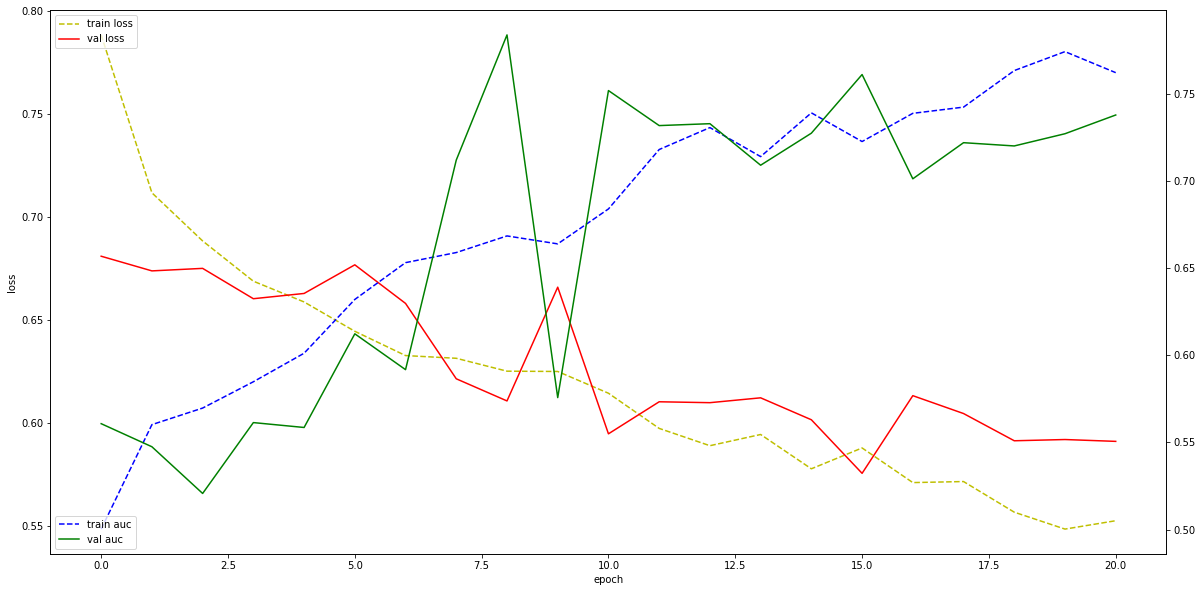

In [56]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
auc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
#auc_ax.plot(hist.history['auc'], 'b', linestyle='dashed',label='train auc')
auc_ax.plot(hist.history[list(hist.history.keys())[1]], 'b', linestyle='dashed',label='train auc')
auc_ax.plot(hist.history[list(hist.history.keys())[3]], 'g', label='val auc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
auc_ax.legend(loc='lower left')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

img = img.imread('model.png')
plt.imshow(img)
plt.show()


## Best model

In [20]:
from keras.models import Model, load_model, model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping

def best_model_path(models_dir):
    model_list = os.listdir(models_dir)
    model_list.sort()
    
    # roc의 경우 오름차순
    if model_list[2][:3] == 'roc':
        model_list = model_list[::-1]
    
    for file in model_list:
        if 'batch' in file:
            return os.path.join(models_dir, file)
    return None


mod_dir = f"../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}_{nfold}fold_test{ntest}_w_samp0(train)_seed98"
odir = best_model_path(mod_dir)
print(odir)

model = model_from_json(open(f'{odir}/model.json', 'rt').read())
#model.load_weights(f'{odir}/weights.hdf5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-savgol_THRES0.9_5fold_test2000_w_samp0(train)_seed98/roc0.786+-0.112_prc0.719+-0.121_max5_batch32,layer1:c64filt3str1,layer2:c16filt7str3,layer3:c32filt13str6,1conv,dropout0.2,dnodes64,dropout0.3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18000, 3)]        0         
                                                                 
 conv1d (Conv1D)             (None, 18000, 64)         640       
                                                                 
 batch_normalization (BatchN  (None, 18000, 64)        256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9000, 64)         0         
 )                                                         

### Validation

In [21]:
kfold = KFold()
cv_scores = []
tprs, aucs, prs = [], [], []
pr_aucs, roc_aucs = [], []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)
idx = 1

for cv_train_mask, cv_test_mask in kfold.split(input_train, y_train_bin):
    model.load_weights(f'{odir}/weights_{idx}.hdf5')
    
    # ROC analysis
    fpr, tpr, t = roc_curve(y_train_bin[cv_train_mask], model.predict(input_train[cv_train_mask]))
    #tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
   
    # PR analysis
    prec, recall, th = precision_recall_curve(y_train_bin[cv_train_mask], model.predict(input_train[cv_train_mask]))
    #prs.append(interp(mean_recall, prec, recall))
    pr_auc = auc(recall, prec)
    
    print(f'fold {idx}: train set roc {roc_auc:.3f}, prc {pr_auc:.3f}    ', end='')
    
    
    
    # ROC analysis
    fpr, tpr, t = roc_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
    #tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
   
    # PR analysis
    prec, recall, th = precision_recall_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
    #prs.append(interp(mean_recall, prec, recall))
    pr_auc = auc(recall, prec)
    
    print(f'val set roc {roc_auc:.3f}, prc {pr_auc:.3f}    ', end='')
    
    
    # ROC analysis
    fpr, tpr, t = roc_curve(y_test_bin, model.predict(input_test))
    #tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
   
    # PR analysis
    prec, recall, th = precision_recall_curve(y_test_bin, model.predict(input_test))
    #prs.append(interp(mean_recall, prec, recall))
    pr_auc = auc(recall, prec)    
    
    print(f'test set roc {roc_auc:.3f}, prc {pr_auc:.3f}    ')

    idx +=1 
    
    
    

fold 1: train set roc 0.709, prc 0.590    val set roc 0.617, prc 0.427    test set roc 0.461, prc 0.440    
fold 2: train set roc 0.809, prc 0.706    val set roc 0.778, prc 0.660    test set roc 0.596, prc 0.454    
fold 3: train set roc 0.921, prc 0.887    val set roc 0.882, prc 0.850    test set roc 0.555, prc 0.449    
fold 4: train set roc 0.925, prc 0.881    val set roc 0.964, prc 0.950    test set roc 0.600, prc 0.489    
fold 5: train set roc 0.902, prc 0.856    val set roc 0.930, prc 0.917    test set roc 0.625, prc 0.490    


In [113]:
kfold = KFold()
cv_scores = []
tprs, aucs, prs = [], [], []
pr_aucs, roc_aucs = [], []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)
idx = 1

for cv_train_mask, cv_test_mask in kfold.split(input_train, y_train_bin):
    model.load_weights(f'{odir}/weights_{idx}.hdf5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    print(f'fold {idx}\n  train')
    model.evaluate(input_train[cv_train_mask], y_train_bin[cv_train_mask])
    print('  val')
    model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask])
    print('  test')
    model.evaluate(input_test, y_test_bin)
    
    #print(f'epoch {idx} train: {model.evaluate(input_train[cv_train_mask], y_train_bin[cv_train_mask])}')
    #print(f'    val: {model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask])}')
    idx +=1 
        

fold 1
  train
27/27 [==============================] - 1s 6ms/step - loss: 0.6458 - auc_26: 0.8926
  val
7/7 [==============================] - 0s 6ms/step - loss: 0.6606 - auc_26: 0.5596
  test
4/4 [==============================] - 0s 6ms/step - loss: 0.6655 - auc_26: 0.5978
fold 2
  train
27/27 [==============================] - 1s 6ms/step - loss: 0.5749 - auc_27: 0.9157
  val
7/7 [==============================] - 0s 6ms/step - loss: 0.5661 - auc_27: 0.9673
  test
4/4 [==============================] - 0s 7ms/step - loss: 0.6624 - auc_27: 0.6225
fold 3
  train
27/27 [==============================] - 1s 6ms/step - loss: 0.4972 - auc_28: 0.9297
  val
7/7 [==============================] - 0s 6ms/step - loss: 0.4750 - auc_28: 0.9835
  test
4/4 [==============================] - 0s 6ms/step - loss: 0.6577 - auc_28: 0.6105
fold 4
  train
27/27 [==============================] - 1s 6ms/step - loss: 0.4062 - auc_29: 0.9455
  val
7/7 [==============================] - 0s 6ms/step - loss

In [117]:
for cv_train_mask, cv_test_mask in kfold.split(input_train, y_train_bin):
    print(np.mean(y_train_bin[cv_train_mask]), np.mean(y_train_bin[cv_test_mask]))
    #input_train[cv_train_mask], y_train_bin[cv_train_mask])

0.3957345971563981 0.3443396226415094
0.3857988165680473 0.38388625592417064
0.38224852071005916 0.3981042654028436
0.3893491124260355 0.3696682464454976
0.3739644970414201 0.4312796208530806


In [94]:
# model 학습 설정

kfold = KFold()
cv_scores = []
tprs, aucs, prs = [], [], []
pr_aucs, roc_aucs = [], []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)
idx = 1
for cv_train_mask, cv_test_mask in kfold.split(input_train, y_train_bin):
    try:
        weightcache = f"{odir}/weights_manual_{idx}.hdf5"
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc", tf.keras.metrics.AUC()])
        hist = model.fit(input_train[cv_train_mask], y_train_bin[cv_train_mask], sample_weight=train_w_samp[cv_train_mask], validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                            EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
        #_, cv_score = model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask], batch_size=batch_size, verbose=0)

        # ROC analysis
        fpr, tpr, t = roc_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        # PR analysis
        prec, recall, th = precision_recall_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
        prs.append(interp(mean_recall, prec, recall))
        pr_auc = auc(recall, prec)
        pr_aucs.append(pr_auc)

        print(f' ###{idx} fold : val auc {roc_auc:.3f}, val prc {pr_auc:.3f}###')
        idx += 1
        
    except:
        None

Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.8488 - acc: 0.4922 - auc_9: 0.5045
Epoch 00001: val_loss improved from inf to 0.68870, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16filt3str1,1conv,dropout0,dnodes64,dropout0.3/weights_manual_1.hdf5
2/2 [==============================] - 2s 510ms/step - loss: 0.8249 - acc: 0.5096 - auc_9: 0.5188 - val_loss: 0.6887 - val_acc: 0.5562 - val_auc_9: 0.4831
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6639 - acc: 0.6152 - auc_9: 0.6433
Epoch 00002: val_loss did not improve from 0.68870
2/2 [==============================] - 0s 77ms/step - loss: 0.6812 - acc: 0.6000 - auc_9: 0.6119 - val_loss: 0.7433 - val_acc: 0.5680 - val_auc_9: 0.4550
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6220 - acc: 0.6328 - auc_9: 0.6795
Epo

/tmp/ipykernel_993142/399274655.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/399274655.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.447, val prc 0.302###
Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.5989 - acc: 0.6621 - auc_10: 0.7016
Epoch 00001: val_loss improved from inf to 0.72030, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16filt3str1,1conv,dropout0,dnodes64,dropout0.3/weights_manual_2.hdf5
2/2 [==============================] - 2s 637ms/step - loss: 0.6117 - acc: 0.6420 - auc_10: 0.6865 - val_loss: 0.7203 - val_acc: 0.5680 - val_auc_10: 0.4728
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.5500 - acc: 0.7227 - auc_10: 0.7749
Epoch 00002: val_loss improved from 0.72030 to 0.68839, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16f

/tmp/ipykernel_993142/399274655.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/399274655.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.558, val prc 0.425###
Epoch 1/100
1/2 [==============>...............] - ETA: 2s - loss: 0.4347 - acc: 0.8145 - auc_11: 0.8783
Epoch 00001: val_loss improved from inf to 1.01897, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16filt3str1,1conv,dropout0,dnodes64,dropout0.3/weights_manual_3.hdf5
2/2 [==============================] - 4s 628ms/step - loss: 0.4279 - acc: 0.8151 - auc_11: 0.8822 - val_loss: 1.0190 - val_acc: 0.5680 - val_auc_11: 0.4534
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.4039 - acc: 0.8145 - auc_11: 0.8937
Epoch 00002: val_loss improved from 1.01897 to 0.85796, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16f

/tmp/ipykernel_993142/399274655.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/399274655.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.675, val prc 0.514###
Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.2708 - acc: 0.9102 - auc_12: 0.9643
Epoch 00001: val_loss improved from inf to 0.86767, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16filt3str1,1conv,dropout0,dnodes64,dropout0.3/weights_manual_4.hdf5
2/2 [==============================] - 2s 531ms/step - loss: 0.2637 - acc: 0.9068 - auc_12: 0.9651 - val_loss: 0.8677 - val_acc: 0.5621 - val_auc_12: 0.4792
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2628 - acc: 0.8984 - auc_12: 0.9618
Epoch 00002: val_loss improved from 0.86767 to 0.86676, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16f

/tmp/ipykernel_993142/399274655.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/399274655.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###4 fold : val auc 0.726, val prc 0.513###
Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.0843 - acc: 0.9902 - auc_13: 0.9995
Epoch 00001: val_loss improved from inf to 0.96502, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16filt3str1,1conv,dropout0,dnodes64,dropout0.3/weights_manual_5.hdf5
2/2 [==============================] - 2s 534ms/step - loss: 0.0776 - acc: 0.9911 - auc_13: 0.9989 - val_loss: 0.9650 - val_acc: 0.5799 - val_auc_13: 0.6877
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1260 - acc: 0.9629 - auc_13: 0.9926
Epoch 00002: val_loss improved from 0.96502 to 0.62713, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/roc0.847+-0.181_prc0.801+-0.246_batch32,layer1:c64filt11str5,layer2:c16f

/tmp/ipykernel_993142/399274655.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/399274655.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
